# Importing Libraries

In [119]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype, is_numeric_dtype

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error

## Memory Management

In [120]:
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Importing the Dataset

In [121]:
# Train Datast
dtypes_df_train = pd.read_csv('./datasets/train_dtypes.csv')
dtypes_train = {k: v for (k, v) in zip(dtypes_df_train.column, dtypes_df_train.dtype)}
t0_df = pd.read_csv('./datasets/train_0.csv', nrows=100000, dtype=dtypes_train)

# Test Dataset
dtypes_df_test = pd.read_csv('./datasets/test_dtypes.csv')
dtypes_test = {k: v for (k, v) in zip(dtypes_df_test.column, dtypes_df_test.dtype)}
test_df = pd.read_csv('./datasets/test.csv', index_col = 'id', nrows=100000, dtype=dtypes_test)

In [122]:
t0_df.head(10)

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,1,1002,-33.313030,-0.0,0.0,1.8548,-0.0,0.0,0.0,41.804798,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
1,1,1002,-33.206146,-0.0,0.0,1.8548,-0.0,0.0,0.0,42.261600,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
2,1,1002,-33.098114,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.227001,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
3,1,1002,-32.993191,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.898399,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
4,1,1002,-32.887756,-0.0,0.0,1.8548,-0.0,0.0,0.0,44.960602,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
5,1,1002,-32.781353,-0.0,0.0,1.8548,-0.0,0.0,0.0,46.470802,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
6,1,1002,-32.671074,-0.0,0.0,1.8548,-0.0,0.0,0.0,47.586601,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
7,1,1002,-32.561630,-0.0,0.0,1.8548,-0.0,0.0,0.0,48.279400,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
8,1,1002,-32.454773,-0.0,0.0,1.8548,-0.0,0.0,0.0,49.321400,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
9,1,1002,-32.342442,-0.0,0.0,1.8548,-0.0,0.0,0.0,51.734600,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0


In [123]:
t0_df.shape

(100000, 61)

In [124]:
t0_df.isna().sum()

game_num                           0
event_id                           0
event_time                         0
ball_pos_x                         0
ball_pos_y                         0
                               ...  
boost5_timer                       0
player_scoring_next                0
team_scoring_next              25878
team_A_scoring_within_10sec        0
team_B_scoring_within_10sec        0
Length: 61, dtype: int64

In [125]:
t0_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 61 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   game_num                     100000 non-null  int32  
 1   event_id                     100000 non-null  int32  
 2   event_time                   100000 non-null  float32
 3   ball_pos_x                   100000 non-null  float32
 4   ball_pos_y                   100000 non-null  float32
 5   ball_pos_z                   100000 non-null  float32
 6   ball_vel_x                   100000 non-null  float32
 7   ball_vel_y                   100000 non-null  float32
 8   ball_vel_z                   100000 non-null  float32
 9   p0_pos_x                     99123 non-null   float32
 10  p0_pos_y                     99123 non-null   float32
 11  p0_pos_z                     99123 non-null   float32
 12  p0_vel_x                     99123 non-null   float32
 13  

In [126]:
t0_df.describe()

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,p5_boost,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,99123.000000,...,99060.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,18.814760,18817.444060,-59.479237,-0.157681,-0.695952,15.415462,0.021327,-0.068358,0.122366,0.525966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.554070,0.054230,0.060830
std,9.987667,9987.574382,52.297665,49.363029,60.329109,10.274729,23.188942,28.203276,12.221605,45.563217,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.140117,0.226472,0.239019
min,1.000000,1002.000000,-292.674805,-80.411201,-104.292801,1.607600,-93.635994,-79.254997,-48.694199,-81.806000,...,0.00000,-9.968750,-9.968750,-9.968750,-9.968750,-9.968750,-9.968750,-1.000000,0.000000,0.000000
25%,10.000000,10004.000000,-86.668505,-44.988649,-55.152101,6.371550,-15.492600,-21.813250,-7.596450,-36.895699,...,12.15625,-5.429688,-5.535156,-6.164062,-6.195312,-5.523438,-5.460938,-1.000000,0.000000,0.000000
50%,19.000000,19001.000000,-44.106070,-0.000000,0.000000,13.850000,-0.000000,0.000000,0.000000,0.673000,...,39.59375,-0.633301,-0.837891,-2.142578,-2.224609,-0.713867,-0.654053,1.000000,0.000000,0.000000
75%,28.000000,28001.000000,-18.529480,44.872102,53.809148,23.179850,15.704800,22.077901,7.610700,37.695099,...,75.31250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
max,36.000000,36001.000000,-0.033333,80.510002,104.308395,39.303001,90.995399,81.708199,55.582996,81.826004,...,100.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,1.000000


In [127]:
t0_df = t0_df.dropna()

In [128]:
pd.DataFrame(t0_df.isna().any())

,0
game_num,False
event_id,False
event_time,False
ball_pos_x,False
ball_pos_y,False
...,...
boost5_timer,False
player_scoring_next,False
team_scoring_next,False
team_A_scoring_within_10sec,False


In [129]:
t0_df1 = t0_df.drop(columns=(['game_num','event_id','event_time','team_scoring_next', 'team_A_scoring_within_10sec', 'team_B_scoring_within_10sec']), axis=1)

# Data Correlation

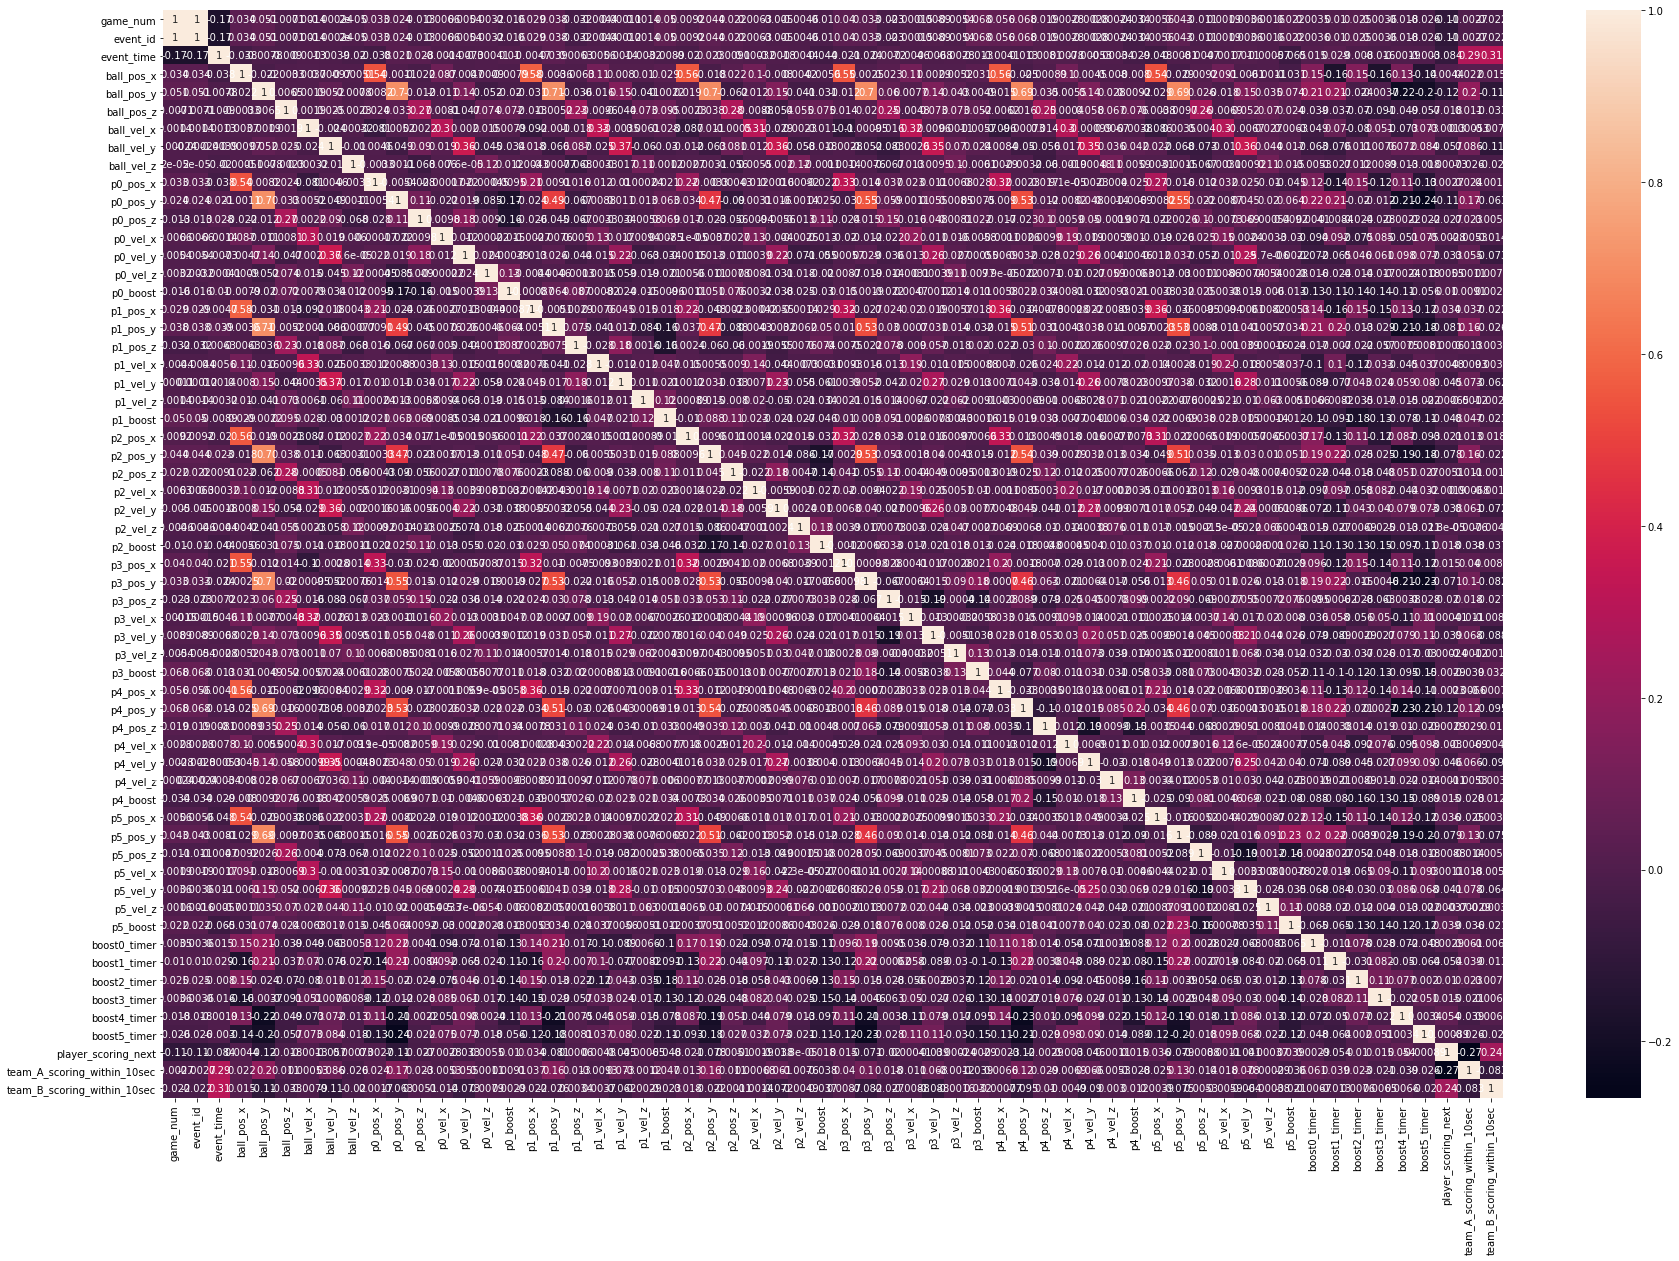

In [133]:
data_corr = t0_df.corr()
plt.figure(figsize=(30,20))
sns.heatmap(data=data_corr, annot=True)
plt.show()

In [134]:
threshold = 0.07
corr=abs(data_corr['team_A_scoring_within_10sec'])
result = corr[corr>threshold]
result.sort_values(ascending=False)

team_A_scoring_within_10sec    1.000000
event_time                     0.292070
player_scoring_next            0.265303
ball_pos_y                     0.196087
p0_pos_y                       0.169444
p2_pos_y                       0.164217
p1_pos_y                       0.162989
p5_pos_y                       0.131774
p4_pos_y                       0.119838
p3_pos_y                       0.101400
ball_vel_y                     0.086063
team_B_scoring_within_10sec    0.083071
p5_vel_y                       0.077678
p1_vel_y                       0.073052
Name: team_A_scoring_within_10sec, dtype: float64

In [135]:
X = t0_df1.drop(['player_scoring_next'], axis=1)
y = t0_df1['player_scoring_next']

In [136]:
# X['team_scoring_next'].unique()

In [137]:
# X['team_scoring_next'] = X['team_scoring_next'].map({'A': 0, 'B': 1})

In [138]:
X

,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,p0_pos_y,p0_pos_z,p0_vel_x,...,p5_vel_x,p5_vel_y,p5_vel_z,p5_boost,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer
0,-0.000000,0.000000,1.8548,-0.000000,0.000000,0.0000,41.804798,-51.924999,0.3402,5.635400,...,-8.227600,-9.275200,-0.0002,22.343750,0.0,0.000000,0.0,0.0,0.000000,0.0
1,-0.000000,0.000000,1.8548,-0.000000,0.000000,0.0000,42.261600,-52.451202,0.3402,5.287199,...,-11.337800,-11.244000,0.0002,30.625000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,-0.000000,0.000000,1.8548,-0.000000,0.000000,0.0000,43.227001,-54.054001,1.1466,5.686000,...,-16.357201,-12.203199,6.2126,26.890625,0.0,0.000000,0.0,0.0,0.000000,0.0
3,-0.000000,0.000000,1.8548,-0.000000,0.000000,0.0000,43.898399,-55.225601,1.5936,10.595600,...,-14.602800,-26.306002,4.9346,23.375000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,-0.000000,0.000000,1.8548,-0.000000,0.000000,0.0000,44.960602,-57.087799,2.0720,10.632600,...,-16.576401,-27.024799,1.3248,19.843750,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,16.319799,28.883799,2.3918,31.140200,-48.812599,-5.9722,-1.640800,90.766602,0.3402,2.412000,...,8.227200,-14.926000,0.0118,0.000000,0.0,-2.078125,0.0,0.0,-2.294922,0.0
99996,19.387400,24.062201,1.9146,28.548201,-45.567001,4.1124,-1.385200,88.674408,0.3402,2.656400,...,8.794800,-15.308200,0.0068,0.000000,0.0,-1.970703,0.0,0.0,-2.187500,0.0
99997,22.948601,18.378000,2.3194,28.437401,-45.392998,2.4736,-0.978000,85.449005,0.3402,3.059400,...,9.190400,-15.593400,0.0068,0.000000,0.0,-1.863281,0.0,0.0,-2.078125,0.0
99998,26.496000,12.715401,2.5198,28.329399,-45.218998,0.8408,-0.709800,83.345596,0.3402,3.340400,...,9.336400,-15.953199,6.5374,0.000000,0.0,-1.754883,0.0,0.0,-1.970703,0.0


# Modeling
> ## Splitting the Dataset

In [139]:
X_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

In [140]:
p_lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

p_knr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])

p_dt = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor())
])

p_rf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

In [141]:
p_lr.fit(X_train, y_train)
p_knr.fit(X_train, y_train)
p_dt.fit(X_train, y_train)
p_rf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestRegressor())])

In [142]:
pred_lr = p_lr.predict(x_val)
pred_knr = p_knr.predict(x_val)
pred_dt = p_dt.predict(x_val)
pred_rf = p_rf.predict(x_val)

In [143]:
lr_r2  = r2_score(y_val,pred_lr )
knr_r2  = r2_score(y_val,pred_knr )
dt_r2 = r2_score(y_val,pred_dt)
rf_r2  = r2_score(y_val,pred_rf )

In [144]:
print('Mean f1 scores:')
print('\nRF mean :',rf_r2, '\nDT mean :',dt_r2, '\nLR mean :',lr_r2, '\nKNR mean :' ,knr_r2)

Mean f1 scores:

RF mean : 0.9401828819210759 
DT mean : 0.753733306860285 
LR mean : 0.03264910770921359 
KNR mean : 0.9858989134074603


In [145]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

pred = model.predict(x_val)
print('R2Score :', r2_score(y_val, pred), '\nMAE :', mean_absolute_error(y_val, pred))

R2Score : 0.9399913333908216 
MAE : 0.30644927536231886


In [146]:
test_df = test_df.dropna()

In [147]:
pred_final = model.predict(test_df)